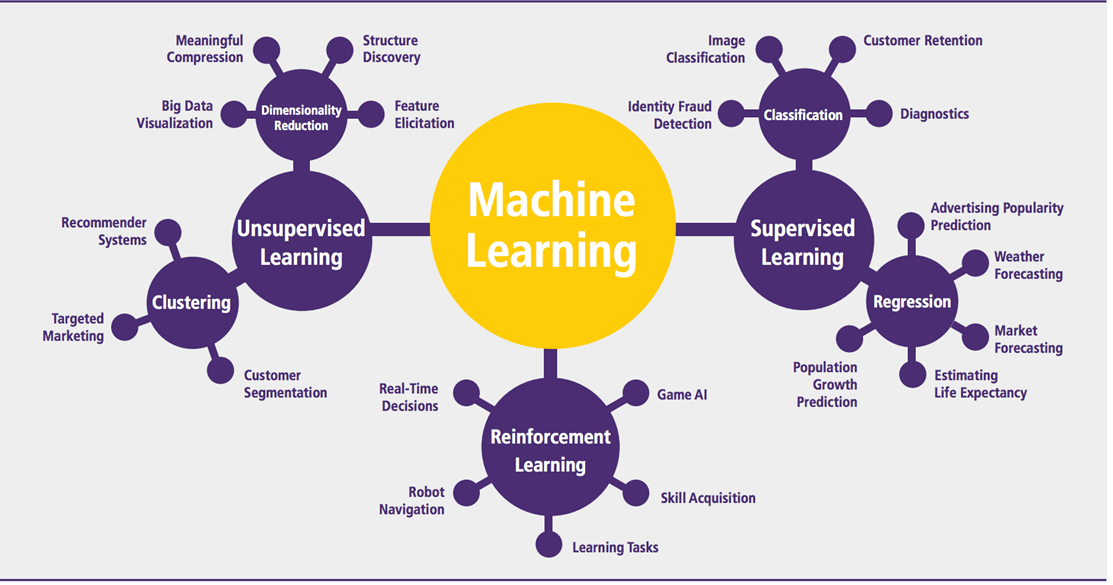

Nos interesa el aprendizaje automático porque podemos diseñar un algoritmo que aprenda por sí mismo a realizar varios análisis, lo que potencialmente nos ahorraría innumerables horas de trabajo humano en diseño y análisis.

El uso del aprendizaje automático en Física de Colisionadores incluye:
* seguimiento de partículas
* identificación de partículas
* clasificación de señal/background.
* ¡y más!

Este cuaderno se centrará en la clasificación de señal/background.

Al final de este cuaderno serás capaz de:
1. ejecutar un Árbol de Decisión Potenciado (Boosted Decision Tree) para clasificar señal y background
2. conocer algunas cosas que puedes modificar para mejorar tu BDT

Las imágenes de los diagramas de Feynman han sido tomadas prestadas de https://www.particlezoo.net


## Ejecutar un cuaderno Jupyter

Para ejecutar todo el cuaderno Jupyter, en el menú superior haz clic en Celda -> Ejecutar Todo (Run All).

Para propagar un cambio que hayas hecho en una porción de código, haz clic en Celda -> Ejecutar Todo Abajo (Run All Below).

También puedes ejecutar una sola celda de código haciendo clic en Celda -> Ejecutar Celdas (Run Cells), o utilizando el atajo de teclado Shift+Enter.


## Configuración inicial

Esta primera celda solo necesita ejecutarse la primera vez que abras este cuaderno.

Instalará algunas herramientas de las que depende este trabajo.


In [67]:
import os

os.system("pip install --upgrade pip -q")  # update the pip package installer
os.system(
    "pip install uproot3 pandas numpy matplotlib scikit-learn requests aiohttp awkward-pandas -q"
)  # install required packages

0

Vamos a utilizar varias herramientas que nos ayudarán:
* uproot: nos permite leer archivos .root, comúnmente usados en física de partículas, y convertirlos a formatos de datos utilizados en aprendizaje automático
* pandas: nos permite almacenar datos en dataframes, un formato ampliamente usado en aprendizaje automático
* numpy: proporciona cálculos numéricos como la creación de histogramas
* matplotlib: herramienta común para crear gráficos, figuras, imágenes y visualizaciones







In [68]:
import uproot  # for reading .root files
import uproot3
import pandas as pd  # to store data as dataframe
import time  # to measure time to analyse
import math  # for mathematical functions such as square root
import numpy as np  # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt  # for plotting
from matplotlib.ticker import AutoMinorLocator  # for minor ticks

## ¡Descubre el bosón de Higgs por ti mismo, usando un BDT!  
Este cuaderno utiliza los datos abiertos de ATLAS http://opendata.atlas.cern para mostrarte los pasos para aplicar aprendizaje automático en la búsqueda del bosón de Higgs.

Los datos abiertos de ATLAS ofrecen acceso libre a datos de colisiones protón-protón en el LHC, con fines educativos. Los recursos de datos abiertos de ATLAS son ideales para estudiantes de secundaria, pregrado y posgrado.

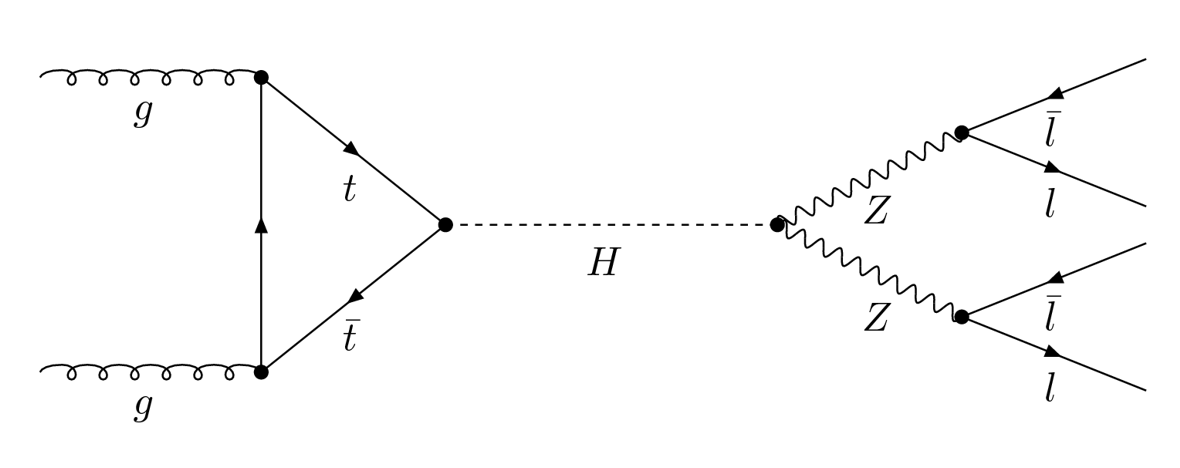


## Luminosidad, fracción, ruta del archivo

Definiciones generales sobre la fracción de datos utilizada y dónde acceder a los archivos de entrada.


In [69]:
lumi = 10  # fb-1 # data_A+B+C+D

fraction = 0.03  # reduce this is you want the code to run quicker

# tuple_path = "Input/4lep/" # local
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/"  # web address

## Muestras

En este cuaderno solo procesamos la señal <span style="color:blue">H->ZZ</span> y el background principal <span style="color:red">ZZ</span>, con fines ilustrativos. Puedes añadir datos y los backgrounds <span style="color:red">Z y ttbar</span> después, si lo deseas.


In [70]:
samples = {
    "ZZ": {"list": ["llll"]},
    r"$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$": {  # H -> ZZ -> llll
        "list": ["ggH125_ZZ4lep"]  # gluon-gluon fusion
    },
}

infos = {
    "ggH125_ZZ4lep": {
        "DSID": 345060,
        "events": 985000,
        "red_eff": 1,
        "sumw": 27881776.6536,
        "xsec": 0.0060239,
    },
    "llll": {
        "DSID": 363490,
        "events": 17825300,
        "red_eff": 1,
        "sumw": 7538705.8077,
        "xsec": 1.2578,
    },
}

# xsec = cross section
# sumw = sum of weights
# red_eff = reduction efficiency
# events = number of events
# DSID = dataset ID

Define la función para obtener datos de los archivos.

Los conjuntos de datos utilizados en este cuaderno ya han sido filtrados para incluir al menos 4 leptones por evento, para que el procesamiento sea más rápido.


In [71]:
# def get_data_from_files():
#     data = {}  # define empty dictionary to hold dataframes
#     for s, sample in samples.items():  # loop over samples
#         print(f"Processing {s} samples")
#         frames = [
#             read_file(
#                 f"{tuple_path}{'Data/' if s == 'data' else 'MC/mc_' + str(infos[val]['DSID']) + '.'}{val}.4lep.root",
#                 val,
#             )
#             for val in sample[
#                 "list"
#             ]  # append dataframe returned from read_file to list of dataframes
#         ]
#         data[s] = pd.concat(
#             frames
#         )  # dictionary entry is concatenated dataframes
#     return data  # return dictionary of dataframes
def get_data_from_files():

    data = {}  # define empty dictionary to hold dataframes
    for s in samples:  # loop over samples
        print("Processing " + s + " samples")  # print which sample
        frames = []  # define empty list to hold data
        for val in samples[s]["list"]:  # loop over each file
            if s == "data":
                prefix = "Data/"  # Data prefix
            else:  # MC prefix
                prefix = "MC/mc_" + str(infos[val]["DSID"]) + "."
            fileString = (
                tuple_path + prefix + val + ".4lep.root"
            )  # file name to open
            temp = read_file(
                fileString, val
            )  # call the function read_file defined below
            frames.append(
                temp
            )  # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(
            frames
        )  # dictionary entry is concatenated dataframes

    return data  # return dictionary of dataframes

Define la función para obtener la sección eficaz


In [72]:
def get_xsec_weight(sample):
    info = infos[sample]  # open infofile
    xsec_weight = (lumi * 1000 * info["xsec"]) / (
        info["sumw"] * info["red_eff"]
    )  # *1000 to go from fb-1 to pb-1
    return xsec_weight  # return cross-section weight

Define la función para obtener el peso estadístico de la muestra


In [73]:
def calc_weight(
    xsec_weight,
    mcWeight,
    scaleFactor_PILEUP,
    scaleFactor_ELE,
    scaleFactor_MUON,
    scaleFactor_LepTRIGGER,
):
    return (
        xsec_weight
        * mcWeight
        * scaleFactor_PILEUP
        * scaleFactor_ELE
        * scaleFactor_MUON
        * scaleFactor_LepTRIGGER
    )

Define la función para devolver los momentos transversales individuales de los leptones, en GeV.


In [74]:
def calc_lep_pt_i(lep_pt, i):
    return lep_pt[i] / 1000  # /1000 to go from MeV to GeV

## Cortes

Aplicamos 'cortes' para desechar colisiones que tienen propiedades diferentes a la señal que estamos buscando.

* Selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge


In [75]:
# cut on lepton charge
def cut_lep_charge(lep_charge):
    # throw away when sum of lepton charges is not equal to 0
    # first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0


# cut on lepton type
def cut_lep_type(lep_type):
    # for an electron lep_type is 11
    # for a muon lep_type is 13
    # throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (
        (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)
    )

## Leer el archivo y aplicar cortes

In [76]:
def read_file(path, sample):
    start = time.time()  # start the clock
    print("\tProcessing: " + sample)  # print which sample is being processed
    data_all = (
        pd.DataFrame()
    )  # define empty pandas DataFrame to hold all data for this sample
    print("path: ", path)
    tree = uproot.open(path)["mini"]  # open the tree called mini
    numevents = len(tree.get("lep_n").array())  # number of events in this tree
    if "data" not in sample:
        xsec_weight = get_xsec_weight(sample)  # get cross-section weight
    for data in tree.iterate(
        [
            "lep_charge",
            "lep_type",
            "lep_pt",
            # uncomment these variables if you want to calculate masses
            # ,'lep_eta','lep_phi','lep_E',
            # add more variables here if you make cuts on them
            "mcWeight",
            "scaleFactor_PILEUP",
            "scaleFactor_ELE",
            "scaleFactor_MUON",
            "scaleFactor_LepTRIGGER",
        ],  # variables to calculate Monte Carlo weight
        library="pd",  # choose output type as pandas DataFrame
        entry_stop=numevents * fraction,  # process up to numevents*fraction
    ):  # process up to numevents*fraction

        nIn = len(data.index)  # number of events in this batch

        if (
            "data" not in sample
        ):  # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data["totalWeight"] = np.vectorize(calc_weight)(
                xsec_weight,
                data.mcWeight,
                data.scaleFactor_PILEUP,
                data.scaleFactor_ELE,
                data.scaleFactor_MUON,
                data.scaleFactor_LepTRIGGER,
            )

        # cut on lepton charge using the function cut_lep_charge defined above
        fail = data[np.vectorize(cut_lep_charge)(data.lep_charge)].index
        data.drop(fail, inplace=True)

        # cut on lepton type using the function cut_lep_type defined above
        fail = data[np.vectorize(cut_lep_type)(data.lep_type)].index
        data.drop(fail, inplace=True)

        # return the individual lepton transverse momenta in GeV
        data["lep_pt_1"] = np.vectorize(calc_lep_pt_i)(data.lep_pt, 0)
        data["lep_pt_2"] = np.vectorize(calc_lep_pt_i)(data.lep_pt, 1)
        data["lep_pt_3"] = np.vectorize(calc_lep_pt_i)(data.lep_pt, 2)
        data["lep_pt_4"] = np.vectorize(calc_lep_pt_i)(data.lep_pt, 3)

        # dataframe contents can be printed at any stage like this
        # print(data)

        # dataframe column can be printed at any stage like this
        # print(data['lep_pt'])

        # multiple dataframe columns can be printed at any stage like this
        # print(data[['lep_pt','lep_eta']])

        nOut = len(data.index)  # number of events passing cuts in this batch
        data_all = pd.concat([data_all, data])
        elapsed = time.time() - start  # time taken to process
        print(
            "\t\t nIn: "
            + str(nIn)
            + ",\t nOut: \t"
            + str(nOut)
            + "\t in "
            + str(round(elapsed, 1))
            + "s"
        )  # events before and after

    return data_all  # return dataframe containing events passing all cuts

In [77]:
start = time.time()  # time at start of whole processing
data = get_data_from_files()  # process all files
elapsed = time.time() - start  # time after whole processing
print(
    "Time taken: " + str(round(elapsed, 1)) + "s"
)  # print total time taken to process every file

Processing ZZ samples
	Processing: llll
path:  https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/MC/mc_363490.llll.4lep.root
		 nIn: 16628,	 nOut: 	15740	 in 6.4s
Processing $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ samples
	Processing: ggH125_ZZ4lep
path:  https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root
		 nIn: 4941,	 nOut: 	4841	 in 5.9s
Time taken: 12.3s


In [78]:
data["ZZ"].head()

,lep_charge,lep_type,lep_pt,mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,scaleFactor_MUON,scaleFactor_LepTRIGGER,totalWeight,lep_pt_1,lep_pt_2,lep_pt_3,lep_pt_4
0,[1 -1 1 -1],[13 13 13 13],[64853.69140625 61677.95703125 48666.44140625 ...,0.126207,1.745631,1.000000,0.994004,0.966761,0.000353,64.853691,61.677957,48.666441,44.360594
1,[-1 1 1 -1],[13 13 11 11],[55921.84765625 41498.75 18562.251953125 11200...,0.332061,0.187531,0.903156,0.995108,0.920816,0.000086,55.921848,41.498750,18.562252,11.200327
2,[-1 1 1 -1],[11 11 13 13],[84155.96875 78250.4609375 56973.08984375 5613...,1.000000,1.241677,0.962309,0.972613,1.005820,0.001950,84.155969,78.250461,56.973090,56.136598
3,[1 -1 -1 1],[11 11 11 11],[100780.21875 26851.66796875 13466.7783203125 ...,1.000000,0.934886,0.857935,1.000000,0.997650,0.001335,100.780219,26.851668,13.466778,11.434911
4,[1 -1 1 -1],[11 11 11 11],[172537.703125 98566.3984375 74528.453125 1257...,0.127306,0.923924,0.904552,1.000000,0.997650,0.000177,172.537703,98.566398,74.528453,12.576789


## Optimización

Aquí definimos histogramas para las variables que buscaremos optimizar.


In [79]:
lep_pt_2 = {  # dictionary containing plotting parameters for the lep_pt_2 histogram
    # change plotting parameters
    "bin_width": 1,  # width of each histogram bin
    "num_bins": 13,  # number of histogram bins
    "xrange_min": 7,  # minimum on x-axis
    "xlabel": r"$lep\_pt$[2] [GeV]",  # x-axis label
}

lep_pt_1 = {  # dictionary containing plotting parameters for the lep_pt_1 histogram
    # change plotting parameters
    "bin_width": 1,  # width of each histogram bin
    "num_bins": 28,  # number of histogram bins
    "xrange_min": 7,  # minimum on x-axis
    "xlabel": r"$lep\_pt$[1] [GeV]",  # x-axis label
}

SoverB_hist_dict = {"lep_pt_2": lep_pt_2, "lep_pt_1": lep_pt_1}
# add a histogram here if you want it plotted

Aquí definimos una función para ilustrar el valor de corte óptimo en variables individuales, basado en la relación de <span style="color:blue">señal</span> a <span style="color:red">background</span>.


In [80]:
def plot_SoverB(data):

    signal = r"$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$"  # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for (
        x_variable,
        hist,
    ) in (
        SoverB_hist_dict.items()
    ):  # access the dictionary of histograms defined in the cell above

        h_bin_width = hist[
            "bin_width"
        ]  # get the bin width defined in the cell above
        h_num_bins = hist[
            "num_bins"
        ]  # get the number of bins defined in the cell above
        h_xrange_min = hist[
            "xrange_min"
        ]  # get the x-range minimum defined in the cell above
        h_xlabel = hist[
            "xlabel"
        ]  # get the x-axis label defined in the cell above

        bin_edges = [
            h_xrange_min + x * h_bin_width for x in range(h_num_bins + 1)
        ]  # bin limits
        bin_centres = [
            h_xrange_min + h_bin_width / 2 + x * h_bin_width
            for x in range(h_num_bins)
        ]  # bin centres

        signal_x = data[signal][x_variable]  # histogram the signal

        mc_x = []  # define list to hold the Monte Carlo histogram entries

        for s in samples:  # loop over samples
            if s not in ["data", signal]:  # if not data nor signal
                mc_x = [
                    *mc_x,
                    *data[s][x_variable],
                ]  # append to the list of Monte Carlo histogram entries

        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca()  # get current axes

        mc_heights = distributions_axes.hist(
            mc_x,
            bins=bin_edges,
            color="red",
            label="Total background",
            histtype="step",  # lineplot that's unfilled
            density=True,
        )  # normalize to form probability density
        signal_heights = distributions_axes.hist(
            signal_x,
            bins=bin_edges,
            color="blue",
            label=signal,
            histtype="step",  # lineplot that's unfilled
            density=True,  # normalize to form probability density
            linestyle="--",
        )  # dashed line

        distributions_axes.set_xlim(
            left=bin_edges[0], right=bin_edges[-1]
        )  # x-limits of the distributions axes
        distributions_axes.set_ylabel(
            "Arbitrary units"
        )  # y-axis label for distributions axes
        distributions_axes.set_ylim(
            top=max(signal_heights[0]) * 1.3
        )  # set y-axis limits
        plt.title(
            "Signal and background " + x_variable + " distributions"
        )  # add title
        distributions_axes.legend()  # draw the legend
        distributions_axes.set_xlabel(h_xlabel)  # x-axis label

        # Add text 'ATLAS Open Data' on plot
        plt.text(
            0.05,  # x
            0.93,  # y
            "ATLAS Open Data",  # text
            transform=distributions_axes.transAxes,  # coordinate system used is that of distributions_axes
            fontsize=13,
        )
        # Add text 'for education' on plot
        plt.text(
            0.05,  # x
            0.88,  # y
            "for education",  # text
            transform=distributions_axes.transAxes,  # coordinate system used is that of distributions_axes
            style="italic",
            fontsize=8,
        )

        plt.show()  # show the Signal and background distributions

        # *************
        # Signal to background ratio
        # *************
        plt.figure()  # start new figure
        SoverB = []  # list to hold S/B values
        for cut_value in bin_edges:  # loop over bins
            signal_weights_passing_cut = sum(
                data[signal][data[signal][x_variable] > cut_value].totalWeight
            )
            background_weights_passing_cut = (
                0  # start counter for background weights passing cut
            )
            for s in samples:  # loop over samples
                if s not in ["data", signal]:  # if not data nor signal
                    background_weights_passing_cut += sum(
                        data[s][data[s][x_variable] > cut_value].totalWeight
                    )
            if (
                background_weights_passing_cut != 0
            ):  # some background passes cut
                SoverB_value = (
                    signal_weights_passing_cut / background_weights_passing_cut
                )
                SoverB_percent = (
                    100 * SoverB_value
                )  # multiply by 100 for percentage
                SoverB.append(SoverB_percent)  # append to list of S/B values

        SoverB_axes = plt.gca()  # get current axes
        SoverB_axes.plot(
            bin_edges[: len(SoverB)], SoverB
        )  # plot the data points
        SoverB_axes.set_xlim(
            left=bin_edges[0], right=bin_edges[-1]
        )  # set the x-limit of the main axes
        SoverB_axes.set_ylabel("S/B (%)")  # write y-axis label for main axes
        plt.title(
            "Signal to background ratio for different "
            + x_variable
            + " cut values",
            family="sans-serif",
        )
        SoverB_axes.set_xlabel(h_xlabel)  # x-axis label

        plt.show()  # show S/B plot

    return

Aquí llamamos a nuestra función para ilustrar el valor de corte óptimo en variables individuales, basado en la relación de <span style="color:blue">señal</span> a <span style="color:red">background</span>.

¡Aún no estamos haciendo ningún aprendizaje automático! Estamos analizando las variables que más tarde utilizaremos para el aprendizaje automático.

Hablemos sobre los gráficos de lep_pt_2.
1. Imagina colocar un corte en 7 GeV en las distribuciones de <span style="color:blue">señal</span> y <span style="color:red">background</span> (1er gráfico). Esto significa mantener todos los eventos por encima de 7 GeV en los histogramas de <span style="color:blue">señal</span> y <span style="color:red">background</span>.
2. Luego tomamos la relación entre el número de eventos de <span style="color:blue">señal</span> que pasan este corte y el número de eventos de <span style="color:red">background</span> que también pasan este corte. Esto nos da un valor inicial para S/B (2do gráfico).
3. Luego aumentamos este valor de corte a 8 GeV, 9 GeV, 10 GeV, 11 GeV y 12 GeV. Los cortes en estos valores están desechando más <span style="color:red">background</span> que <span style="color:blue">señal</span>, por lo que S/B aumenta.
4. Llega un punto alrededor de 13 GeV donde comenzamos a desechar demasiada <span style="color:blue">señal</span>, por lo que S/B comienza a disminuir.
5. Nuestro objetivo es encontrar el máximo en S/B y colocar el corte allí.

La misma lógica se aplica a lep_pt_1.


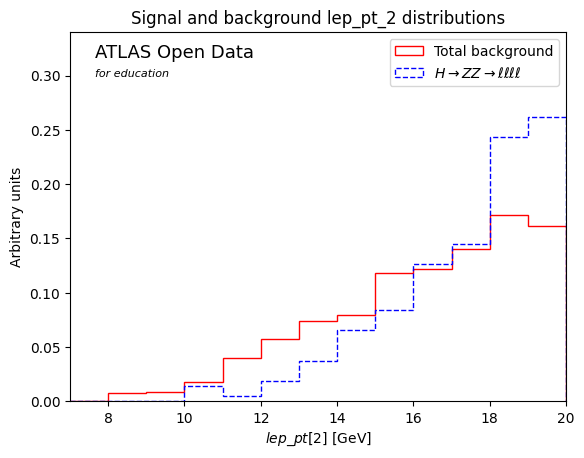

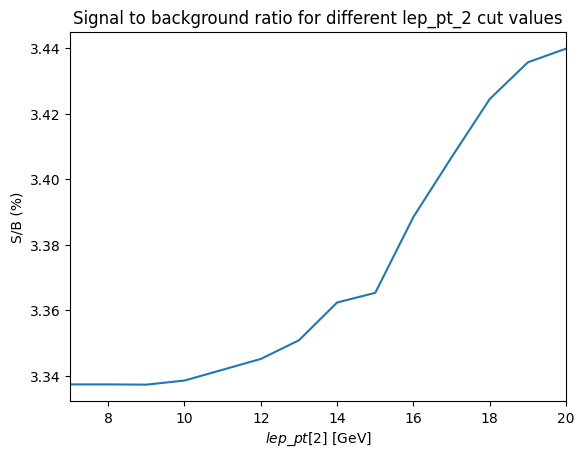

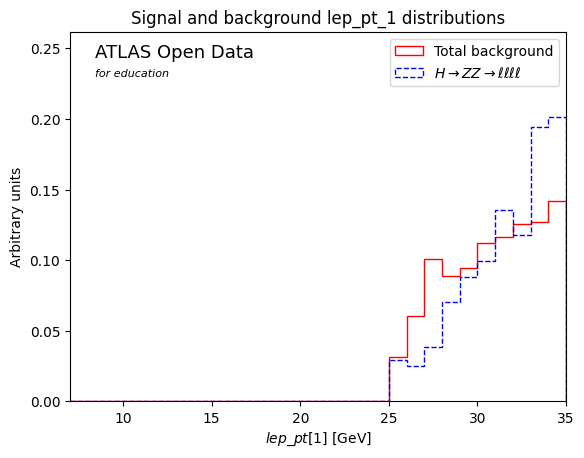

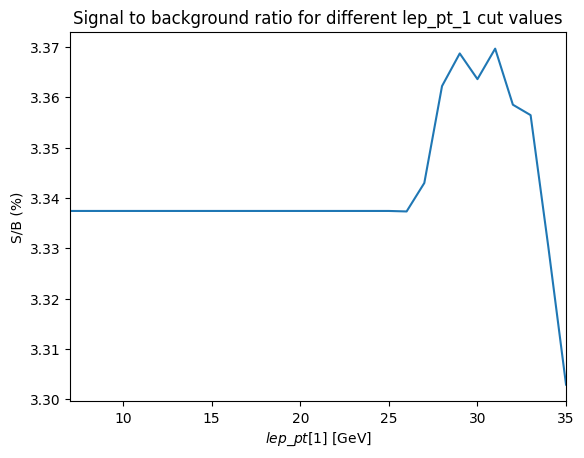

In [81]:
plot_SoverB(data)

En el [artículo de descubrimiento del Higgs de ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X), se aplican varios cortes numéricos, no solo en lep_pt_1 y lep_pt_2.

¡Imagina tener que optimizar por separado alrededor de 7 variables! Sin mencionar que aplicar un corte en una variable podría cambiar la distribución de otra, lo que significaría que tendrías que reoptimizar... Una pesadilla.

Aquí es donde un algoritmo de aprendizaje automático como un BDT puede venir al rescate. Un BDT puede optimizar todas las variables al mismo tiempo.

Un BDT no solo optimiza los cortes, sino que puede encontrar correlaciones en múltiples dimensiones que proporcionarán una mejor clasificación de señal/background de lo que podrían lograr los cortes individuales.

Eso es el final de la introducción sobre por qué uno podría querer utilizar un BDT. Si deseas intentar usar uno, ¡sigue leyendo a continuación!


## Árbol de Decisión Potenciado (BDT)

Selecciona variables para usar en el BDT.


In [82]:
data_for_BDT = (
    {}
)  # define empty dictionary to hold dataframes that will be used to train the BDT
BDT_inputs = [
    "lep_pt_1",
    "lep_pt_2",
    "lep_pt_3",
    "lep_pt_4",
]  # define the input variables for the BDT
for (
    key
) in data:  # loop over the different keys in the dictionary of dataframes
    data_for_BDT[key] = data[key][BDT_inputs].copy()
    data_for_BDT[key].index.name = (
        "event_id"  # set the index name to 'event' for the ZZ dataframe
    )
data_for_BDT["ZZ"].head()  # print the first few rows of the ZZ dataframe

,lep_pt_1,lep_pt_2,lep_pt_3,lep_pt_4
event_id,,,,
0,64.853691,61.677957,48.666441,44.360594
1,55.921848,41.498750,18.562252,11.200327
2,84.155969,78.250461,56.973090,56.136598
3,100.780219,26.851668,13.466778,11.434911
4,172.537703,98.566398,74.528453,12.576789


### Organiza los datos listos para el BDT.


In [83]:
# for sklearn data is usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples

# Collect all MC features
all_MC = [data_for_BDT[key] for key in data if key != "data"]
X = np.concatenate(all_MC)

# Collect labels: 0 for background, 1 for signal
all_y = [
    np.zeros(data_for_BDT[key].shape[0])
    for key in data
    if key not in ["data", r"$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$"]
]
all_y.append(
    np.ones(
        data_for_BDT[r"$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$"].shape[
            0
        ]
    )
)
y = np.concatenate(all_y)

### La División de Entrenamiento y Pruebas

Una de las primeras cosas que hay que hacer es dividir tus datos en un conjunto de entrenamiento y un conjunto de prueba. 

Esto dividirá tus datos en conjuntos de entrenamiento y prueba: 67%-33%. 

También mezclará las entradas para que no obtengas el primer 67% de <span style="color:orange">X</span> para el entrenamiento y el último 33% para la prueba. Esto es particularmente importante en casos donde primero cargas todos los eventos de <span style="color:blue">señal</span> y luego los eventos de <span style="color:red">background</span>.

Aquí dividimos nuestros datos en dos muestras independientes. La división es para crear un conjunto de entrenamiento y un conjunto de prueba. El primero se utilizará para entrenar al clasificador y el segundo para evaluar su rendimiento.

No queremos probar en eventos que usamos para entrenar, ya que esto previene el sobreajuste a un subconjunto de datos, lo que haría que la red funcionara bien con los datos de prueba pero mucho peor con cualquier dato *nuevo* que vea.


In [84]:
from sklearn.model_selection import train_test_split

# make train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=492
)

### Entrenamiento de Árboles de Decisión

Usaremos SciKit Learn (sklearn) en este tutorial. Otras herramientas posibles incluyen keras y pytorch.

Aquí establecemos varios hiperparámetros con valores distintos a los predeterminados.

Después de instanciar nuestro <span style="color:orange">AdaBoostClassifier</span>, llama al método <span style="color:orange">fit()</span> con la muestra de entrenamiento como argumento. Esto entrenará el árbol; ahora estamos listos para evaluar el rendimiento en el conjunto de prueba retenido.


In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=2)  # maximum depth of the tree
bdt = AdaBoostClassifier(
    dt,
    algorithm="SAMME",  # SAMME discrete boosting algorithm
    n_estimators=12,  # max number of estimators at which boosting is terminated
    learning_rate=0.5,
)  # shrinks the contribution of each classifier by learning_rate

start = time.time()  # time at start of BDT fit
bdt.fit(X_train, y_train)  # fit BDT to training set
elapsed = time.time() - start  # time after fitting BDT
print(
    "Time taken to fit BDT: " + str(round(elapsed, 1)) + "s"
)  # print total time taken to fit BDT
print(bdt)

Time taken to fit BDT: 0.1s
AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=12)


El método <span style="color:orange">fit()</span> devuelve el clasificador entrenado. Al imprimirlo, se enumeran todos los hiperparámetros.


### Evaluación del Desempeño de un Clasificador

A continuación, vamos a crear un informe rápido sobre qué tan bien está funcionando nuestro clasificador. Es importante asegurarse de usar muestras que no hayan sido vistas por el clasificador para obtener una estimación imparcial de su rendimiento.


In [86]:
from sklearn.metrics import classification_report, roc_auc_score

y_predicted = bdt.predict(X_test)  # get predicted y for test set
print(
    classification_report(
        y_test, y_predicted, target_names=["background", "signal"]
    )
)
print(
    "Area under ROC curve for test data: %.4f"
    % (roc_auc_score(y_test, bdt.decision_function(X_test)))
)

              precision    recall  f1-score   support

  background       0.88      0.87      0.88      5194
      signal       0.60      0.62      0.61      1598

    accuracy                           0.81      6792
   macro avg       0.74      0.75      0.74      6792
weighted avg       0.82      0.81      0.81      6792

Area under ROC curve for test data: 0.8648


Para ilustrar este punto, aquí están las mismas métricas de rendimiento evaluadas en el conjunto de entrenamiento en su lugar. Las estimaciones del rendimiento son más optimistas que en un conjunto de eventos no vistos.


In [87]:
y_predicted = bdt.predict(X_train)  # get predicted y for train set
print(
    classification_report(
        y_train, y_predicted, target_names=["background", "signal"]
    )
)
print(
    "Area under ROC curve for training data: %.4f"
    % (roc_auc_score(y_train, bdt.decision_function(X_train)))
)

              precision    recall  f1-score   support

  background       0.89      0.88      0.88     10546
      signal       0.62      0.64      0.63      3243

    accuracy                           0.82     13789
   macro avg       0.75      0.76      0.75     13789
weighted avg       0.82      0.82      0.82     13789

Area under ROC curve for training data: 0.8748


### Curva Característica Operativa del Receptor (ROC) para BDT

Otro gráfico útil para evaluar el rendimiento de un clasificador es observar directamente la curva ROC.


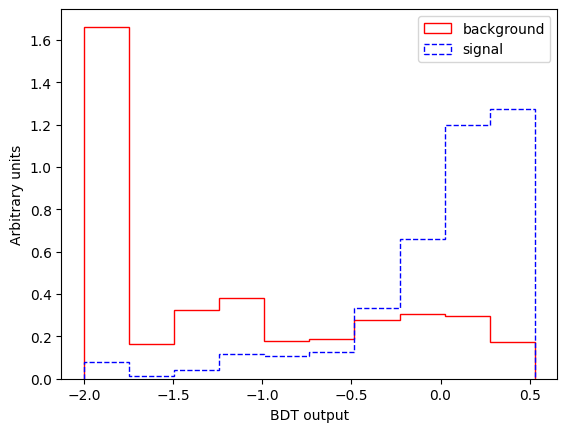

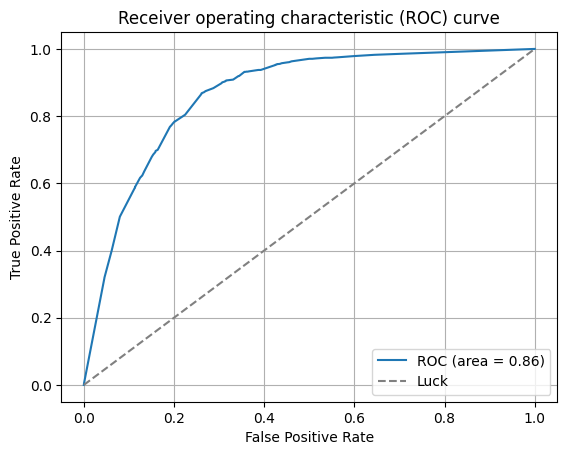

In [88]:
# we first plot the Neural Network output
signal_decisions = bdt.decision_function(X[y>0.5]).ravel() # get probabilities on signal
background_decisions = bdt.decision_function(X[y<0.5]).ravel() # get decisions on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('BDT output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend


# we then plot the ROC
plt.figure() # make new figure 

from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test).ravel() # get probabilities on test set

# Compute ROC curve and area under the curve
fpr, tpr, _ = roc_curve(y_test, # actual
                        decisions ) # predicted

# Compute area under the curve for training set
roc_auc = auc(fpr, # false positive rate 
              tpr) # true positive rate

plt.plot(fpr, tpr, label='ROC (area = %0.2f)'%(roc_auc)) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='grey', label='Luck')

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic (ROC) curve') # title
plt.legend() # add legend
plt.grid() # add grid

Deslizar el umbral de corte en la salida de la red neuronal (gráfico superior) de derecha a izquierda construye la curva ROC (gráfico inferior) de abajo hacia arriba.


### Verificación de Overfitting del BDT

Comparar la distribución de salida del BDT para el conjunto de entrenamiento y el conjunto de prueba es una forma popular en la física de partículas (HEP) de verificar el sobreajuste. El método <span style="color:orange">compare_train_test()</span> trazará la forma de la función de decisión del BDT para cada clase, así como superpondrá esta información con la función de decisión en el conjunto de entrenamiento.

Existen técnicas para prevenir el sobreajuste.


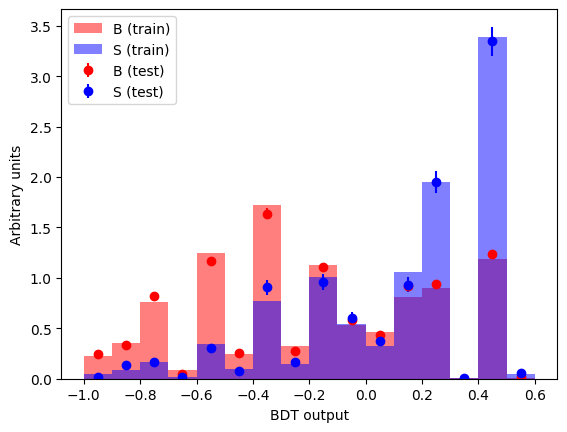

In [89]:
def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.decision_function(X[y<0.5]).ravel() # background
        d2 = clf.decision_function(X[y>0.5]).ravel() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -1.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)
    
    plt.xlabel("BDT output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
    
compare_train_test(bdt, X_train, y_train, X_test, y_test) # call compare_train_test

### Optimización del BDT

Aquí obtenemos la función de decisión del BDT para cada evento que se procesó al principio (por lo que podría ser datos, <span style="color:blue">señal</span>, <span style="color:red">background</span>, etc.). Cuanto mayor sea la función de decisión, más piensa el BDT que ese evento se asemeja a <span style="color:blue">señal</span>.


In [90]:
y_predicted = bdt.decision_function(X)
y_predicted

array([-2.        ,  0.43037804, -2.        , ...,  0.22359316,
       -0.78273511,  0.43037804])

En esta celda, guardamos la salida del BDT en nuestros dataframes.


In [91]:
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in data: # loop over samples
    data[key]['BDT_output'] = y_predicted[cumulative_events:cumulative_events+len(data[key])]
    cumulative_events += len(data[key]) # increment counter for total number of events
    print(data[key]['BDT_output']) # print the dataframe column BDT_output

0       -2.000000
1        0.430378
2       -2.000000
3       -0.019093
4       -1.249420
           ...   
16623    0.228679
16624   -1.001648
16625   -1.237292
16626   -2.000000
16627    0.182606
Name: BDT_output, Length: 15740, dtype: float64
0       0.430378
1       0.430378
2      -0.024179
3       0.182606
4      -1.237292
          ...   
4935    0.223593
4936   -2.000000
4937    0.223593
4938   -0.782735
4940    0.430378
Name: BDT_output, Length: 4841, dtype: float64


Aquí definimos los parámetros para graficar la salida del BDT.


In [92]:
BDT_output = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':14, # number of histogram bins
    'xrange_min':-1, # minimum on x-axis
    'xlabel':'BDT output', # x-axis label
}

SoverB_hist_dict = {'BDT_output':BDT_output}

Aquí llamamos a la función definida anteriormente para ilustrar el valor de corte óptimo en la salida del BDT, basado en la relación de <span style="color:blue">señal</span> a <span style="color:red">background</span>.

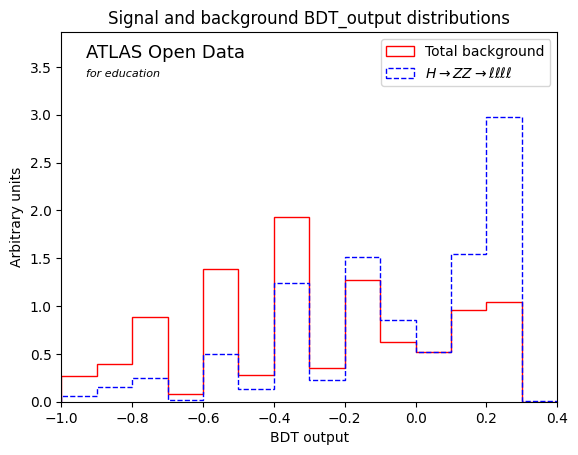

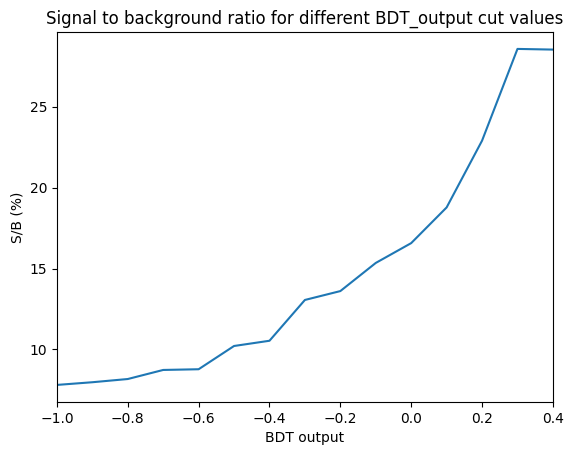

In [93]:
plot_SoverB(data)

Al poner todo en un BDT, solo tenemos 1 variable para optimizar. Las distribuciones de <span style="color:blue">señal</span> y <span style="color:red">background</span> están mucho mejor separadas al observar la salida del BDT, en comparación con las variables individuales. Cortar en la salida del BDT también logra valores de S/B mucho más altos que en las variables individuales.

Los BDT pueden lograr mejores ratios de S/B porque encuentran correlaciones en muchas dimensiones que proporcionan una mejor clasificación de señal/background.

Esperamos que hayas disfrutado esta discusión sobre la optimización de la relación de <span style="color:blue">señal</span> a <span style="color:red">background</span>, y en particular cómo se puede utilizar un BDT para facilitar esto.


## Ir más allá

Si deseas profundizar más, hay varias cosas que podrías intentar:
* Aumentar la fracción de eventos que se procesan en '[Lumi, fracción, ruta del archivo](#fraction)'.
* Agregar las otras muestras de <span style="color:blue">H->ZZ señal</span> en '[Muestras](#samples)'. Puedes copiarlas de [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb). Intenta agregar una a la vez primero y luego observa cómo se ven con todas agregadas.
* Agregar las muestras de background Z y ttbar en '[Muestras](#samples)'. Puedes copiarlas de [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb). Intenta agregarlas por separado primero y luego observa cómo se ven con ambas agregadas.
* Agregar algunas variables más en '[Árbol de Decisión Potenciado (BDT)](#BDT)'. Agrégalas una a la vez, en lugar de todas a la vez, porque agregar una variable podría disminuir el rendimiento del BDT debido a la anticorrelación. Para algunas ideas de variables, puedes consultar el artículo sobre el [descubrimiento del bosón de Higgs por ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (principalmente Sección 4 y 4.1).
* Agregar datos reales en '[Muestras](#samples)' y ver si las distribuciones de salida del BDT en datos y simulación coinciden. Puedes copiar datos de [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb).
* Modificar algunos hiperparámetros del BDT en '[Entrenamiento de Árboles de Decisión](#training)'.

Con cada cambio, mantén un ojo en:
* el área total bajo la curva ROC,
* la separación entre <span style="color:blue">señal</span> y <span style="color:red">background</span> en la distribución de salida del BDT,
* las puntuaciones de S/B que se pueden lograr.

Ten en cuenta que hemos entrenado y probado nuestro BDT en datos simulados. Luego lo *aplicaríamos* a datos experimentales reales. Una vez que estés satisfecho con tu BDT, es posible que desees integrarlo de nuevo en un análisis completo para ejecutarlo sobre todos los datos.
